In [ ]:
!pip install ortools
!pip install request


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [ ]:
def resolver_problema(tipo_solver):

  from ortools.linear_solver import pywraplp
  import json
  import requests
  import time

  response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/incidentes2019.json")
  incidents_db = json.loads(response.text)

  response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones_barrios.json")
  distances_stations_ntas_db = json.loads(response.text)

  response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones.json")
  distances_stations_db = json.loads(response.text)

  response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/barrios.json")
  ntas_db = json.loads(response.text)

  response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/estaciones.json")
  stations_db = json.loads(response.text)

  # DECLARACIÓN Y CREACIÓN DEL SOLVER

  solver = pywraplp.Solver.CreateSolver(tipo_solver)

  # DEFINICIÓN DE PARÁMETROS
  N = [1,2,3,4,5]
  N[0] = 197
  N[1] = 143
  N[2] = 5
  N[3] = 8
  N[4] = 1


  tipos_vehiculos = [1,2,3,4,5]
  tipos_vehiculos[0] = 197
  tipos_vehiculos[1] = 143
  tipos_vehiculos[2] = 5
  tipos_vehiculos[3] = 8
  tipos_vehiculos[4] = 1

  distritos = [1,2,3,4,5]
  distritos[0]=1
  distritos[1]=2
  distritos[2]=3
  distritos[3]=4
  distritos[4]=5


  max_i = 5
  max_j = 218
  max_k = 2
  max_d = 5

  # CREACIÓN DE VARIABLES

  # Supongamos que tienes una matriz X definida previamente
  # Aquí se asume como una lista de listas para simplificar el ejemplo
  X = {}
  for i in range(0, max_i):
        for j in range(0,max_j):
          for k in range(0, 2):
              X[i, j, k] = solver.IntVar(0, solver.infinity(), f'X[{i},{j},{k}]')

  # Creación de las variables binarias V
  V = {}
  for i in range(0, max_i):
      for j in range(0, max_j):
          for k in range(0, 2):
              V[i, j, k] = solver.IntVar(0, 1, f'V[{i},{j},{k}]')



  # SJ
  Sj = {}  # Diccionario que almacena la suma de las distancias de los 5 barrios más cercanos
  for station, distances in distances_stations_ntas_db.items():
      # Obtener las distancias de los 5 barrios más cercanos
      top5_distances = sorted(distances.values())[:5]

      # Calcular la suma de las distancias
      suma_distancias = sum(top5_distances)

      # Almacenar la suma de las distancias en el diccionario Sj
      Sj[station] = suma_distancias


  # PJ


  Pj = {}  # Diccionario que almacena la población de los barrios asociados a cada estación
  poblacion_total = 0  # Variable que guarda la población total

  for station, distances in distances_stations_ntas_db.items():
      # Obtención de los 5 barrios con distancias más cortas
      top5_neighborhoods = sorted(distances, key=distances.get, reverse=False)[:5]

      # Asignación al diccionario Pj
      Pj[station] = top5_neighborhoods

      # Cálculo de la población total de la estación actual
      station_population = 0
      for neighborhood in top5_neighborhoods:
          # Encontrar el nombre del barrio correspondiente a la distancia en ntas_db
          for barrio_info in ntas_db:
              if barrio_info["nta"] == neighborhood:
                  # Suman la población del barrio a la población total de la estación
                  station_population += barrio_info["population"]

      Pj[station]=station_population
      # Sumar la población total de la estación a la población total general
      poblacion_total += station_population





  A = 100  # Peso asociado a la población de los barrios
  B = 50  # Peso asociado a la suma de las distancias entre la estación y los barrios


  # Función objetivo
  #print(Sj[1], len(Sj))
  lista_sj = list(Sj.items())
  sj_n = [valor for valor in Sj.values() if isinstance(valor, (int, float))]
  pj_n = [valor for valor in Pj.values() if isinstance(valor, (int, float))]

  objective = solver.Objective()
  objective.SetMaximization()
  for i in range(0, max_i):
      for j in range(0, max_j):
          for k in range(0, 2):
            score = A * pj_n[j] - B * sj_n[j]
            objective.SetCoefficient(X[i,j,k],score) # donde pone 1 debe ir el peso



  #RESTRICCIONES

  # Inicializar la restricción 1
  for i in range(0, max_i):
      for k in range(0, 2):
          # Calcular el valor necesario para cumplir con la restricción
          required_value = tipos_vehiculos[i]
          res = solver.Constraint(required_value, required_value)

          for j in range(max_j):
            res.SetCoefficient(X[i,j,k], 1)



  #Restricción 2
  for j in range(0, max_j):
      for k in range(0, 2):
          # La suma de las variables X_i,j,k para i desde 1 hasta 5 debe ser mayor o igual a 1
            res = solver.Constraint(-solver.infinity(), stations_db[j]["capacity"])
            for i in range(max_i):
              res.SetCoefficient(X[i,j,k], 1)

  #Restricción 3

  for j in range(0, max_j):
      for k in range(0, 2):
          # La suma de las variables X_i,j,k para i desde 1 hasta 5 debe ser mayor o igual a 1
            res = solver.Constraint(1, solver.infinity())
            for i in range(max_i):
              res.SetCoefficient(X[i,j,k], 1)

  #Restriccion 4


  from collections import Counter


  bx_stations = []
  si_stations = []
  mn_stations = []
  qn_stations = []
  bk_stations = []

  for station, distances in distances_stations_ntas_db.items():
      # Obtener los 5 vecindarios con las distancias más cortas
      top5_neighborhoods = sorted(distances, key=distances.get, reverse=False)[:5]

      # Obtener las dos primeras letras de cada vecindario
      two_letters = [neighborhood[:2] for neighborhood in top5_neighborhoods]

      # Contar las ocurrencias de las dos primeras letras
      letter_counts = Counter(two_letters)
      #print(letter_counts)

      # Seleccionar la más común y, en caso de empate, elegir una de las mayores
      most_common_letter = max(letter_counts, key=lambda k: (letter_counts[k], k), default=None)



      # Almacenar el resultado en las listas
      if most_common_letter == 'BX':
        bx_stations.append(station)
      elif most_common_letter == 'SI':
        si_stations.append(station)
      elif most_common_letter == 'MN':
        mn_stations.append(station)
      elif most_common_letter == 'QN':
        qn_stations.append(station)
      elif most_common_letter == 'BK':
        bk_stations.append(station)
  '''
# Imprimir el resultado
  print("Lista BX:", bx_stations)
  print("Lista SI:", si_stations)
  print("Lista MN:", mn_stations)
  print("Lista QN:", qn_stations)
  print("Lista BK:", bk_stations)
  '''


# Las estaciones están ordenadas en stations_db según el distrito en el que se encuentran

#MN: 0-47
#BX: 48-81
#BK: 82-147
#QN: 148-198
#SI: 199-218


  # Bucle externo for sobre i (excepto quinto tipo) para aplicar a cada tipo de vehículo, con bucle interno k, para cada turno k
  # Debe cumplir que la suma de vehículos en las estaciones de cada distrito para cada tipo i (excepto quinto tipo) y turno j (constraint_expr) sea superior al 5% de vehículos totales en cada tipo
  # Se realiza el mismo código para cada distrito

  #MN
  for i in range(0, 4):
    for k in range(0, 2):
      constraint_expr = solver.Sum([X[i, j, k] for j in range(0,48)])
      solver.Add(constraint_expr >= 0.05*tipos_vehiculos[i])

  #BX
  for i in range(0, 4):
    for k in range(0, 2):
      constraint_expr = solver.Sum([X[i, j, k] for j in range(48,82)])
      solver.Add(constraint_expr >= 0.05*tipos_vehiculos[i])

  #BK
  for i in range(0, 4):
      for k in range(0, 2):
        constraint_expr = solver.Sum([X[i, j, k] for j in range(82,148)])
        solver.Add(constraint_expr >= 0.05*tipos_vehiculos[i])

  #QN
  for i in range(0, 4):
      for k in range(0, 2):
        constraint_expr = solver.Sum([X[i, j, k] for j in range(148,199)])
        solver.Add(constraint_expr >= 0.05*tipos_vehiculos[i])

  #SI
  for i in range(0, 4):
      for k in range(0, 2):
        constraint_expr = solver.Sum([X[i, j, k] for j in range(199,218)])
        solver.Add(constraint_expr >= 0.05*tipos_vehiculos[i])


  #Restricción 5

  e = 1
  M = 5

  for i in range(0, max_i):
    for j in range(0, max_j):
      for k in range(0, 2):
          sum_of_x = solver.Sum([X[i, j, k] for i in range(0, max_i)]) # Aquí se calcula la suma de variables 'X' para un conjunto fijo de valores de 'j' y 'k' y un conjunto variable de la 'i', representando una determianda cantidad de vehículos de tipo i asignado a una estación 'j' en un turno 'k'
          sum_of_v = solver.Sum([V[i, j, k] for i in range(0, max_i)]) # Aquí se calcula la suma de variables 'V' para un conjunto fijo de valores de 'j' y 'k' y un conjunto variable de la 'i', representando 'V' una varibale binaria

          solver.Add(V[i, j, k] <= X[i, j, k]) #Aseguramnos V <= X, por lo que V se activaría solo si el valor de X es positivo. Las próximas dos líneas refuerzan esta condición, mediante el uso de las constantes M y e
          solver.Add(e * V[i, j, k] <= X[i, j, k])
          solver.Add(X[i, j, k] <= M * V[i, j, k])

          solver.Add(sum_of_x >= e * sum_of_v) #Estas dos líneas aseguran que el total de X se mantenga dentro de los límites definidos por el producto de sum_of_v y lasconstantes e y M
          solver.Add(sum_of_x <= M * sum_of_v)


  #Restricción 6
  max_movements_per_turn = 25
  for i in [2, 3, 4]:  # Vehículos de tipo 2, 3 y 4 solamente ya que son los que nos interesan para implementar esta restricción
      for k in range(1):  # Solo para k = 0, ya que esto representa el cambio de turno
          total_movements = solver.Sum(
              [V.get((i, j, j_prime, k), 0) for j in range(max_j) for j_prime in range(max_j) if j != j_prime] #Suma total de movimientos de cada tipo de vehículo 'i'  puede realizar entre diferentes estaciones
          )
          solver.Add(total_movements <= max_movements_per_turn) # Aseguramos que esta suma no exceda el límite de movimientos definido



  #RESULTADOS DEL MODELO


  result = solver.Solve()
  print("Result:", objective.Value())

  if result == solver.ABNORMAL :
    print("Se ha producido un error mientras se ejecutaba el solver")
  elif result == solver.FEASIBLE :
    print("Se ha encontrado una solución factible")
    print("Valor para la variable", X[i,j,k].name(), 'es de', X[i,j,k].solution_value())
    print("El valor de la solución es de", objective.Value())
  elif result == solver.INFEASIBLE :
    print("El problema no tiene solución posible")
  elif result == solver.NOT_SOLVED :
    print("No se ha podido encontrar ninguna solución en el tiempo proporcionado")
  elif result == solver.OPTIMAL :
    print("Ha encontrado la solución óptima")
    print("Valor para la variable", X[i,j,k].name(), 'es de', X[i,j,k].solution_value())
    print("El valor de la solución es de", objective.Value())
    print("Se han requerido un total de ", solver.Iterations(), "iteraciones del algoritmo para su resolución")
  elif result == solver.UNBOUNDED :
    print("Solución no acotada por las restricciones")
  else :
    print("Código de error desconocido")

  '''
  for i in range(0, max_i):
     for j in range(0,max_j):
         for k in range(0, 2):
          if(X[i,j,k].solution_value()>0):
           print(X[i,j,k].name(), X[i,j,k].solution_value())
  '''


In [ ]:
import time
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from numpy import average, std
import numpy as np


tipos_solvers = ["CBC","SCIP"]

times = {solver: [] for solver in tipos_solvers}
#times=[]
for tipo_solver in tipos_solvers:
    for _ in range(10):
        start_time = time.time()
        resolver_problema(tipo_solver)
        end_time = time.time()
        times[tipo_solver].append(end_time - start_time)

media = []
desviacion = []
for solver, time_list in times.items():
    media.append(np.mean(time_list))
    desviacion.append(np.std(time_list))
'''
for tipo_solver in tipos_solvers:
  start_time = time.time()
  resolver_problema(tipo_solver)
  end_time = time.time()
  print("Solver type:", tipo_solver, "Time:", end_time - start_time, "seconds")
  times.append(end_time-start_time)
'''

print(times)

Result: 16097934574.0
Ha encontrado la solución óptima
Valor para la variable X[4,217,0] es de 0.0
El valor de la solución es de 16097934574.0
Se han requerido un total de  302 iteraciones del algoritmo para su resolución
Result: 16097934574.0
Ha encontrado la solución óptima
Valor para la variable X[4,217,0] es de 0.0
El valor de la solución es de 16097934574.0
Se han requerido un total de  302 iteraciones del algoritmo para su resolución
Result: 16097934574.0
Ha encontrado la solución óptima
Valor para la variable X[4,217,0] es de 0.0
El valor de la solución es de 16097934574.0
Se han requerido un total de  302 iteraciones del algoritmo para su resolución
Result: 16097934574.0
Ha encontrado la solución óptima
Valor para la variable X[4,217,0] es de 0.0
El valor de la solución es de 16097934574.0
Se han requerido un total de  302 iteraciones del algoritmo para su resolución
Result: 16097934574.0
Ha encontrado la solución óptima
Valor para la variable X[4,217,0] es de 0.0
El valor de l

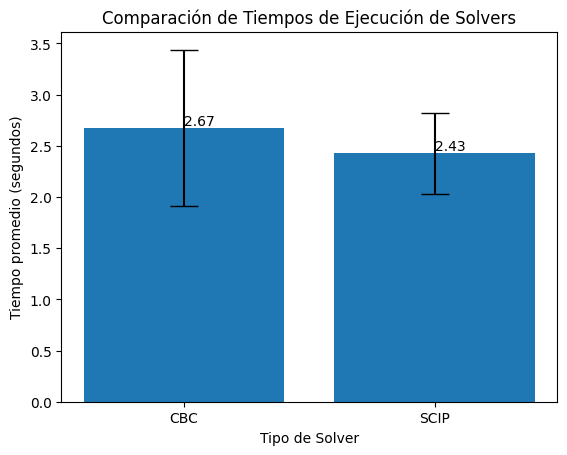

In [ ]:
# Crear el gráfico de barras
fig, ax = plt.subplots()
barras = ax.bar(tipos_solvers, media, yerr=desviacion, capsize=10)
ax.set_xlabel('Tipo de Solver')
ax.set_ylabel('Tiempo promedio (segundos)')
ax.set_title('Comparación de Tiempos de Ejecución de Solvers')

# Añadir etiquetas con los tiempos exactos en cada barra
for barra in barras:
    yval = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), va='bottom')  # Ajusta la posición y el formato del texto

plt.show()